In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import seaborn as sb
mpl.rcParams["figure.figsize"] = (15,8)
import numpy as np
import matplotlib.pyplot as plt
import stingray.simulator as ss
from stingray.lightcurve import Lightcurve
from stingray.events import EventList
from tqdm import tqdm
import matplotlib as mpl
import time

mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['ytick.major.size'] = 15
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['xtick.major.size'] = 15
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2

from astropy.table import Table
import ipyparallel as ipp

def pulsar_events_mp(length, period, ctrate, pulsed_fraction, mean_obs, bkg_ctrate, detlev, nbin = 128):
    
    nustar_orb = 5808
    
    dt = period / 20
    # The total length of the time series should be the number of pointings times the time per orbit. 
    # Add one orbit for buffer.
    N_orb = int(round(length/mean_obs, 0))
    tot_len = (N_orb + 1)*nustar_orb

    # The orbital period is 5808s. Every 5808s, a continuous observation with min_obs < length < max_obs begins
    start_t = numpy.arange(N_orb) * numpy.random.uniform(low=nustar_orb-120, high= nustar_orb +120, size = N_orb)
    point_t = numpy.random.uniform(low=mean_obs-500, high= mean_obs + 500, size = N_orb)
    end_t = start_t + point_t
    print(numpy.column_stack((start_t, end_t)))

    times = numpy.arange(dt/2, tot_len + dt/2, dt)
    cont_lc = numpy.random.poisson((ctrate * (1 + pulsed_fraction * numpy.cos(2 * numpy.pi / period * times)) * dt)) + numpy.random.poisson(bkg_ctrate*dt)
    
    lc = Lightcurve(time=times, counts= cont_lc, gti= numpy.column_stack((start_t, end_t)), dt=dt, skip_checks=True)
    exposure = numpy.sum(point_t)
    events = EventList()
    events.gti = lc.gti
    events.simulate_times(lc)
    phase = numpy.arange(0, 1, 1 / nbin)
    zsq = z_n(phase, n=2,
              norm=fold_events(events.time, 1/period, nbin=nbin)[1])
    detected = zsq > detlev
    return (detected, exposure)

def detected_pulse_fraction_mp(pf_min, pf_max, length_min, length_max, 
                            ctrate_min=1.4, ctrate_max=1.4, 
                            period_min=1, period_max=1, n_realizations=1000, 
                            ntrial=1000, results=None, nbin=128, min_mean_obs = 3000, max_mean_obs = 3250, 
                            bkg_ctrate = 0, cores = 8):
    if results is None:
        results = Table(names=["period", "countrate", "pf", 
                               "length", "mean_obs", "detected"], 
                        dtype=[float, float, float, float, float, bool])

    pfs = 10**np.random.uniform(np.log10(pf_min), 
                                np.log10(pf_max), n_realizations)
    lengths = 10**np.random.uniform(np.log10(length_min), 
                                    np.log10(length_max), n_realizations)
    periods = 10**np.random.uniform(np.log10(period_min), 
                                    np.log10(period_max), n_realizations)
    ctrates = 10**np.random.uniform(np.log10(ctrate_min), 
                                    np.log10(ctrate_max), n_realizations)
    mean_obss = 10**np.random.uniform(np.log10(min_mean_obs), 
                                    np.log10(max_mean_obs), n_realizations)
    
    c = ipp.Client()
    v = c[:]
    with v.sync_imports():
        import numpy
        from stingray.events import EventList
        from stingray.lightcurve import Lightcurve
        from stingray.pulse.pulsar import z_n, fold_events
        from stingray.stats import z2_n_detection_level
        
    detlev = z2_n_detection_level(ntrial=ntrial)
    map_results = v.map(pulsar_events_mp, lengths, periods, ctrates, pfs, mean_obss, [bkg_ctrate for i in range(n_realizations)], [detlev for i in range(n_realizations)])
    c.wait_interactive()
    c.shutdown()
    for i in range(n_realizations):
        pf, period, ctrate, mean_obs = pfs[i], periods[i], ctrates[i], mean_obss[i]
        detected, length = map_results[i]
        results.add_row([period, ctrate, pf, length, mean_obs, detected])
    
    return results




# Simulate

In [2]:
# Using count rates from WebPIMMS and period from Reig and Zezas 2014
ctrate = 3.5
bkg = 0.005
period = 1.0
pfmin, pfmax = 0.20, 0.60
lengthmin, lengthmax = 20000, 50000
ctrate_min, ctrate_max = ctrate, ctrate
period_min, period_max = 320, 320

table_len_pf = detected_pulse_fraction_mp(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000, bkg_ctrate = bkg)

   8/8 tasks finished after  154 s
done


In [3]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [4]:
idx = np.arange(len(table_len_pf), dtype=int)
indices_train = np.random.randint(0, len(table_len_pf), len(table_len_pf)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table_len_pf)) if k not in indices_train])
full_dataset = np.array(table_len_pf["pf", "length"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table_len_pf["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table_len_pf["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [9]:
linear_clf.fit(np.log10(features_train), labels_train)


ValueError: The number of classes has to be greater than one; got 1 class

In [8]:
linear_clf.score(np.log10(features), labels)

AttributeError: 'SVC' object has no attribute 'shape_fit_'

In [9]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, len_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

In [10]:
from IPython.display import display, Math, Latex
display(Math(r"${:.2f} + {:.2f} \log_{{10}} F + {:.2f} \log_{{10}} L = 0$".format(const, pf_fact, len_fact)))
display(Math(r"${:.2f} \log_{{10}} F + \log_{{10}} L = {:.2f}$".format(pf_fact / len_fact, -const / len_fact)))

display(Math(r"$F^{" + "{:.2f}".format(pf_fact / len_fact) + "}" + " L = {:.2f}$".format(10**(-const / len_fact))))

NameError: name 'const' is not defined

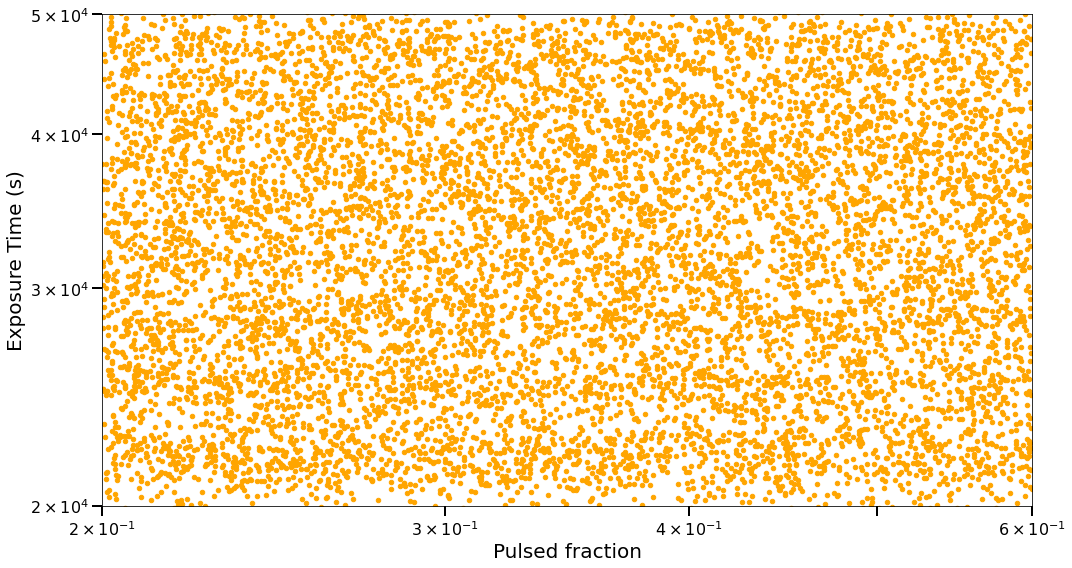

In [11]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(lengthmin, lengthmax, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

# proba = linear_clf.predict_proba(np.log10(Xfull))

# proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))

good = table_len_pf["detected"] == True
bad = np.logical_not(good)
plt.scatter(table_len_pf["pf"][bad], table_len_pf["length"][bad], color="cyan", s=20)
plt.scatter(table_len_pf["pf"][good], table_len_pf["length"][good], color="orange", s=20)
plt.xlabel("Pulsed fraction")
plt.ylabel("Exposure Time (s)")
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([lengthmin, lengthmax])
# plt.([4e4, 1e5, 3e5])
# plt.axhline(1.0e5, ls=':', color='blue', label='Proposed ' + r'$NuSTAR$' + ' observation', lw=8)
# plt.axhline(1.8e4, ls=':', color='grey', lw=8)
# plt.axhline(3.6e4, ls=':', color='grey', lw=8)
# plt.axhline(4.0e4, ls=':', color='grey', label='Previous ' + r'$NuSTAR$' + ' observations', lw=8)

# ax = plt.gca()
# C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
# F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
# plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=5)

# print()
# levels = [0.01, 0.1, 0.9, 0.99]
# CS = plt.contour(xx, yy, proba_detection, levels, 
#                  linestyles='dashed', colors='k')
# plt.clabel(CS, inline=1, fontsize=20)
# plt.legend(loc=2, fontsize=21, framealpha=1.0)
plt.tight_layout()
plt.savefig('/Users/sean/Desktop/detection_len_pf_highflux.pdf')